<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [162]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [163]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = "d:\\capstone_websites"

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [229]:
import datetime
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    with open(site_freq_path, "rb") as f:
        freq_dict=pickle.load(f)
    s=glob(os.path.join(path_to_csv_files,'*.csv'))
    s.sort(key=str.lower)
    cols=[]
    for k in range(session_length):
        cols.append("site"+str(k+1))
    #cols.append("user_id")
    long_list_sites=[]
    list_starttimes=[]
    long_list_deltatimes=[]
    list_users=[]
    for filename in s:
        user_id=int(filename[-8:-4])
        start_site_num=0
        d=pd.read_csv(filename)
        count=0
        starttime_for_user=datetime.datetime.strptime(d["timestamp"][0],"%Y-%m-%d %H:%M:%S")
        current_time=starttime_for_user
        while start_site_num<d.shape[0]:
            list_starttimes.append(datetime.datetime.strptime(d["timestamp"][start_site_num],"%Y-%m-%d %H:%M:%S"))
            for k in range(session_length):
                try:
                    long_list_sites.append(freq_dict[d["site"][k+start_site_num]][0])
                except Exception:
                    long_list_sites.append(0)
                try:
                    current_time=datetime.datetime.strptime(d["timestamp"][k+start_site_num],"%Y-%m-%d %H:%M:%S")
                    long_list_deltatimes.append((datetime.datetime.strptime(d["timestamp"][k+start_site_num+1],"%Y-%m-%d %H:%M:%S")-current_time).total_seconds())
                except Exception:
                    long_list_deltatimes.append(0)
            list_users.append(user_id)
            start_site_num+=window_size
    array_sites=np.array(long_list_sites).reshape(len(list_users),session_length)
    array_deltatimes=np.array(long_list_deltatimes).reshape(len(list_users),session_length)
    users=pd.DataFrame(data=array_sites, columns=cols)
    deltatimes=pd.DataFrame(data=array_deltatimes, columns=cols)
    if "session_timespan" in feature_names:
        users["session_timespan"]=deltatimes.apply(lambda x: np.sum(x)-x["site"+str(session_length)],axis=1)
        #вообще-то это странно, получается время посещения не всех 10 сайтов, а 9
    if "#unique_sites" in feature_names:
        users["#unique_sites"]=users[cols].apply(lambda x: len(set(x)-set([0])), axis=1)
    if "start_hour" in feature_names:
        users["start_hour"]=map(lambda x:x.hour, list_starttimes)
    if "day_of_week" in feature_names:
        users["day_of_week"]=map(lambda x:x.weekday(),list_starttimes)
    users["user_id"]=list_users
    return users

**Проверим функцию на игрушечном примере.**

In [230]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [231]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,4,2,2,11,2,1,8,5,9,7,7998.0,8,9,4,1
1,4,1,1,1,0,0,0,0,0,0,60.0,2,12,4,1
2,4,2,6,6,2,0,0,0,0,0,7935.0,3,9,4,2
3,3,1,2,1,2,1,1,5,10,3,7998.0,5,9,4,3
4,3,1,2,0,0,0,0,0,0,0,1471.0,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [232]:
%%time
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 14.2 s


In [233]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,192,586,134,3,134,134,3,134,204,134,33.0,5,8,4,31
1,416,193,683,256,134,31,393,3514,217,55,284.0,10,8,4,31
2,55,3,55,55,5,293,416,337,918,55,258.0,7,8,4,31
3,483,3735,483,55,55,55,55,982,201,123,30.0,6,8,4,31
4,348,55,5,4459,259,212,4216,2418,684,2418,6.0,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [234]:
%%time
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 2min 26s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [235]:
new_features_10users =train_data_10users.iloc[:,-5:-1].values
new_features_150users =train_data_150users.iloc[:,-5:-1].values

In [236]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [237]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['user_id'].map(id_name_dict)

In [238]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

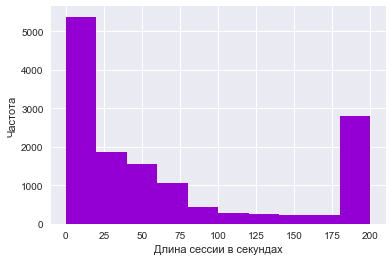

In [239]:
plt.hist(train_data_10users['session_timespan'].map(lambda x: min(x,200)),color="darkviolet")
#plt.hist(train_data_10users['session_timespan'],range=(0,200),color="darkviolet")
plt.xlabel(u"Длина сессии в секундах")
plt.ylabel(u"Частота")

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

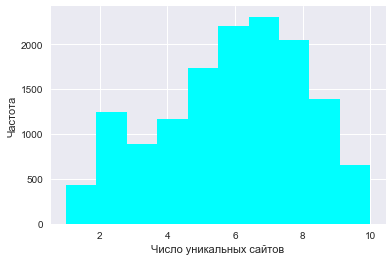

In [240]:
plt.hist(train_data_10users['#unique_sites'],color="aqua")
plt.xlabel(u"Число уникальных сайтов")
plt.ylabel(u"Частота")

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

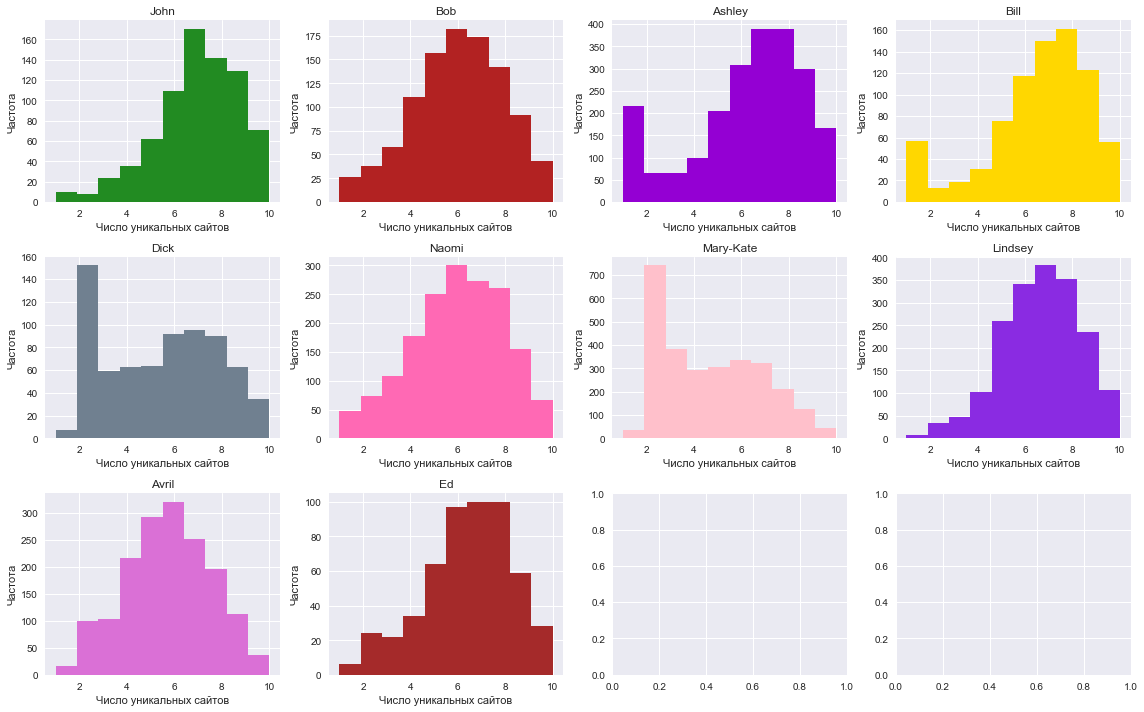

In [241]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')):
    row=int(idx/4)
    col=idx-row*4
    axes[row,col].hist(sub_df["#unique_sites"],color=color_dic[id_name_dict[user]])
    axes[row,col].set_title(id_name_dict[user])
    axes[row,col].set_xlabel(u"Число уникальных сайтов")
    axes[row,col].set_ylabel(u"Частота")
fig.tight_layout()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

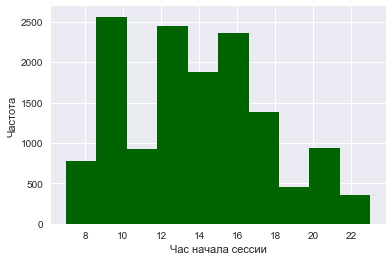

In [242]:
plt.hist(train_data_10users['start_hour'],color="darkgreen")
plt.xlabel(u"Час начала сессии")
plt.ylabel(u"Частота")

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

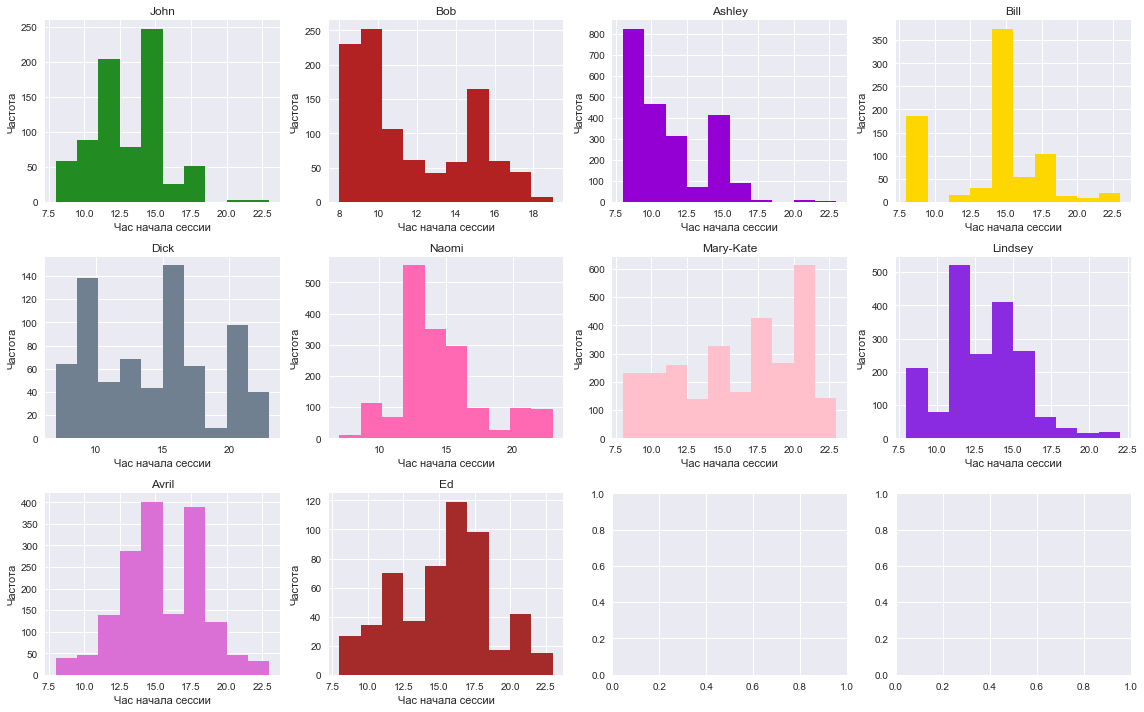

In [243]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')):
    row=int(idx/4)
    col=idx-row*4
    axes[row,col].hist(sub_df["start_hour"],color=color_dic[id_name_dict[user]])
    axes[row,col].set_title(id_name_dict[user])
    axes[row,col].set_xlabel(u"Час начала сессии")
    axes[row,col].set_ylabel(u"Частота")
fig.tight_layout()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

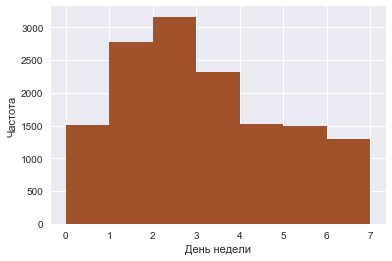

In [244]:
plt.hist(train_data_10users['day_of_week'],color="sienna",bins=[0,1,2,3,4,5,6,7])
plt.xlabel(u"День недели")
plt.ylabel(u"Частота")

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

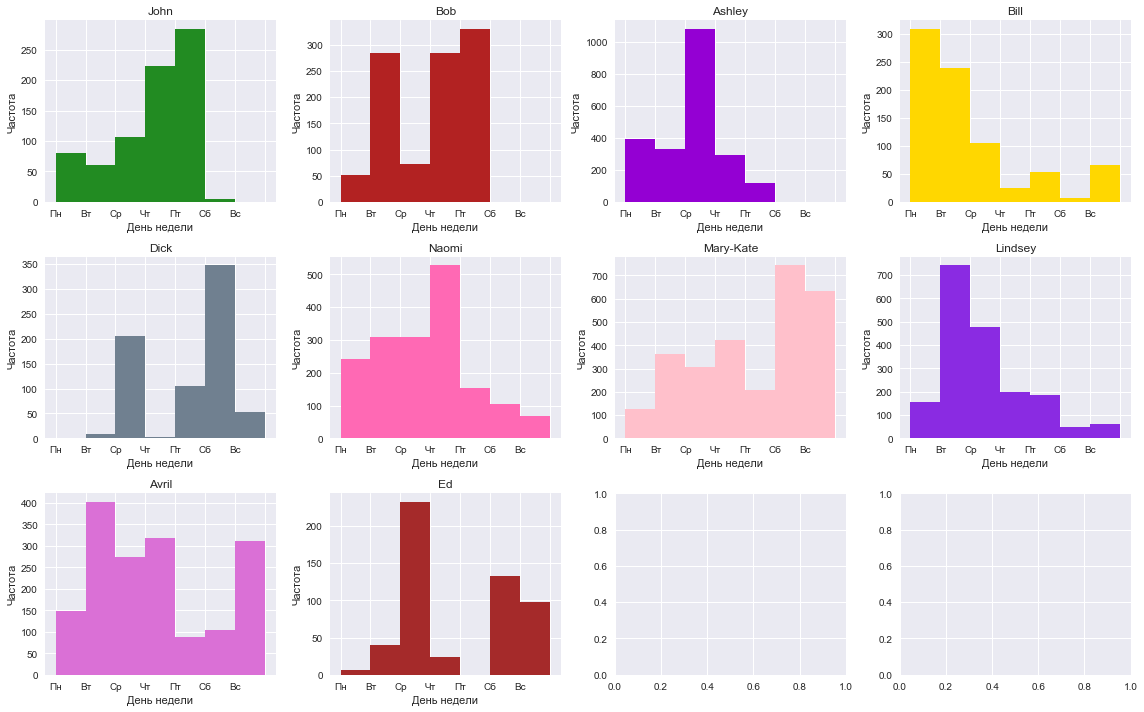

In [245]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')):
    row=int(idx/4)
    col=idx-row*4
    axes[row,col].hist(sub_df["day_of_week"],color=color_dic[id_name_dict[user]],bins=[0,1,2,3,4,5,6,7])
    axes[row,col].set_title(id_name_dict[user])
    axes[row,col].set_xlabel(u"День недели")
    axes[row,col].set_ylabel(u"Частота")
    axes[row,col].set_xticks([0,1,2,3,4,5,6,7] )
    axes[row,col].set_xticklabels([ u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'] )
fig.tight_layout()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

John: чаще заходит в первой половине дня, в будние дни, ходит на разные сайты

Bob: чаще всегда заходит утром, практически никогда - вечером, в будние дни, может возвращаться к просмотренным сайтам

Ashley: чаще всего заходит утром, изредка вечером, в будние дни, ходит на разные сайты

Bill: заходит и утром, и днем, и вечером, во все дни, ходит на разные сайты

Dick: заходит в разное время, чаще всего по средам и субботам, может возвращаться к просмотренным сайтам

Naomi: заходит и утром, и днем, и вечером, чаще утром, во все дни, чаще разные сайты

Mary-Kate: заходит и утром, и днем, и вечером, чаще вечером, во все дни, часто возвращается к сайтам

Lindsey: заходит и утром, и днем, и вечером, чаще утром, во все дни, может возвращаться к просмотренным сайтам

Avril: заходит и утром, и днем, и вечером, чаще днем, во все дни, может возвращаться к просмотренным сайтам

Ed: заходит и утром, и днем, и вечером, чаще днем, почти никогда в пятницу, может возвращаться к просмотренным сайтам



**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [378]:
with open("d:\\capstone_websites\site_freq_10users.pkl", "rb") as f:
        freq_dict=pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [379]:
sites_freqs={item:freq_dict[item][1] for item in freq_dict}
sorted_sites=sorted(sites_freqs, key=sites_freqs.get,reverse=True)
top10_sites =sorted_sites[:10]
top10_freqs = [sites_freqs[x] for x in top10_sites]
print(top10_sites)
print(top10_freqs)

['s.youtube.com', 'www.google.fr', 'www.google.com', 'mail.google.com', 'www.facebook.com', 'apis.google.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com', 'accounts.google.com']
[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089]


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

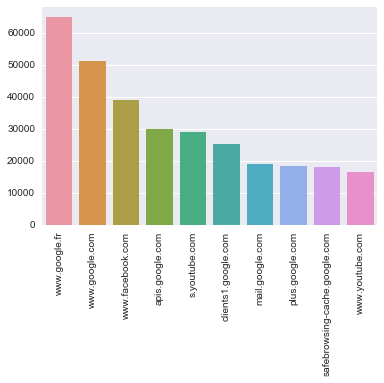

In [369]:
bp=sns.barplot(x=top10_sites, y=top10_freqs)
for item in bp.get_xticklabels():
    item.set_rotation(90)

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [ ]:
print(np.median(train_data_10users["session_timespan"]))

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [ ]:
print(np.median(train_data_10users["day_of_week"]))

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [ ]:
print(np.median(train_data_150users["start_hour"]))

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [ ]:
print(np.median(train_data_150users["#unique_sites"]))

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

popular_ind - индикатор пребывания на топ-30 популярных сайтов

max_time - максимальное за сессию время пребывания на одном сайте

av_visits_google - среднее количество посещений google - сайтов:
www.google.fr
www.google.com
google.fr
google.com
www.google.dz
www.google.com.pe
www.google.co.ma
google.ezakus.net
www.google.ru
www.google.cd
www.google.bj
www.google.co.uk
www.google.bi
www.google.com.hk
www.google.dj
www.google.co.in
www.google.de
google.com.pe
www.google.be
www.google.ca
google.ru
www.google.hk
www.google.com.br
www.google.es
www.google.sn
www.google.com.cn
www.google.ie
www.google.hk.cn
www.google.cn
www.google.ch

av_visits_facebook - среднее количество посещений facebook-сайтов:
www.facebook.com
s-static.ak.facebook.com
static.ak.facebook.com
connect.facebook.net
graph.facebook.com
api.facebook.com
fr-fr.facebook.com
static.ak.connect.facebook.com
facebook.com
badge.facebook.com
apps.facebook.com
facebook.fr
developers.facebook.com
facebook.madmoo.com
api-read.facebook.com
m.facebook.com
facebook-web-clients.appspot.com
ar-ar.facebook.com
facebookcomment.moderatus.netino.com
fr.facebook.com
browse.unblock-facebookproxy.com
static-0.facebook.com
www.facebook.fr
facebook.computing.net
code.facebook.com
l.facebook.com
www.frasesparafacebook.info
facebook.pangaea.nl
b.s-static.ak.facebook.com

In [406]:
def feature_engineering(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10):
    with open(site_freq_path, "rb") as f:
        freq_dict=pickle.load(f)
    google_nums=[]
    facebook_nums=[]
    for site in freq_dict:
        if site[:11]=="www.google.":
            google_nums.append(freq_dict[site][0])
        if site[:7]=="google.":
            google_nums.append(freq_dict[site][0])
        if "facebook" in site:
            facebook_nums.append(freq_dict[site][0])
    s=glob(os.path.join(path_to_csv_files,'*.csv'))
    s.sort(key=str.lower)
    cols=[]
    for k in range(session_length):
        cols.append("site"+str(k+1))
    long_list_sites=[]
    list_starttimes=[]
    long_list_deltatimes=[]
    list_users=[]
    for filename in s:
        user_id=int(filename[-8:-4])
        start_site_num=0
        d=pd.read_csv(filename)
        count=0
        starttime_for_user=datetime.datetime.strptime(d["timestamp"][0],"%Y-%m-%d %H:%M:%S")
        current_time=starttime_for_user
        while start_site_num<d.shape[0]:
            list_starttimes.append(datetime.datetime.strptime(d["timestamp"][start_site_num],"%Y-%m-%d %H:%M:%S"))
            for k in range(session_length):
                try:
                    long_list_sites.append(freq_dict[d["site"][k+start_site_num]][0])
                except Exception:
                    long_list_sites.append(0)
                try:
                    current_time=datetime.datetime.strptime(d["timestamp"][k+start_site_num],"%Y-%m-%d %H:%M:%S")
                    long_list_deltatimes.append((datetime.datetime.strptime(d["timestamp"][k+start_site_num+1],"%Y-%m-%d %H:%M:%S")-current_time).total_seconds())
                except Exception:
                    long_list_deltatimes.append(0)
            list_users.append(user_id)
            start_site_num+=window_size
    array_sites=np.array(long_list_sites).reshape(len(list_users),session_length)
    array_deltatimes=np.array(long_list_deltatimes).reshape(len(list_users),session_length)
    users=pd.DataFrame(data=array_sites, columns=cols)
    deltatimes=pd.DataFrame(data=array_deltatimes, columns=cols)
    if "session_timespan" in feature_names:
        users["session_timespan"]=deltatimes.apply(lambda x: np.sum(x)-x["site"+str(session_length)],axis=1)
        #вообще-то это странно, получается время посещения не всех 10 сайтов, а 9
    if "#unique_sites" in feature_names:
        users["#unique_sites"]=users[cols].apply(lambda x: len(set(x)-set([0])), axis=1)
    if "start_hour" in feature_names:
        users["start_hour"]=map(lambda x:x.hour, list_starttimes)
    if "day_of_week" in feature_names:
        users["day_of_week"]=map(lambda x:x.weekday(),list_starttimes)
    if "popular_ind" in feature_names:
        users["popular_ind"]=users[cols].apply(lambda x: 1 if len([a for a in x if a<=30])>0 else 0, axis=1)
    if "max_time" in feature_names:
        users["max_time"]=deltatimes[cols].apply(lambda x: np.max(x), axis=1)
    if "av_visits_google" in feature_names:
        users["av_visits_google"]=users[cols].apply(lambda x:len([a for a in x if a in google_nums]),axis=1)
    if "av_visits_facebook" in feature_names:
        users["av_visits_facebook"]=users[cols].apply(lambda x:len([a for a in x if a in facebook_nums]),axis=1)
    users["user_id"]=list_users
    return users

In [407]:
feature_names=["popular_ind","max_time","av_visits_google","av_visits_facebook"]
new_features_3users=feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)
new_features_3users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,popular_ind,max_time,av_visits_google,av_visits_facebook,user_id
0,4,2,2,11,2,1,8,5,9,7,1,6278.0,1,0,1
1,4,1,1,1,0,0,0,0,0,0,1,55.0,3,0,1
2,4,2,6,6,2,0,0,0,0,0,1,6278.0,0,0,2
3,3,1,2,1,2,1,1,5,10,3,1,6278.0,4,0,3
4,3,1,2,0,0,0,0,0,0,0,1,1184.0,1,0,3


In [408]:
%%time
new_features_10users=feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)
new_features_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,popular_ind,max_time,av_visits_google,av_visits_facebook,user_id
0,192,586,134,3,134,134,3,134,204,134,1,20.0,2,0,31
1,416,193,683,256,134,31,393,3514,217,55,0,163.0,0,0,31
2,55,3,55,55,5,293,416,337,918,55,1,242.0,1,1,31
3,483,3735,483,55,55,55,55,982,201,123,0,25.0,0,0,31
4,348,55,5,4459,259,212,4216,2418,684,2418,1,1.0,0,1,31


In [411]:
%%time
new_features_150users=feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)
new_features_150users.head()

Wall time: 3min 4s


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

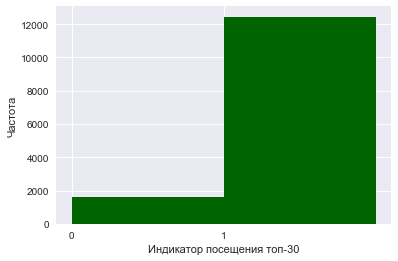

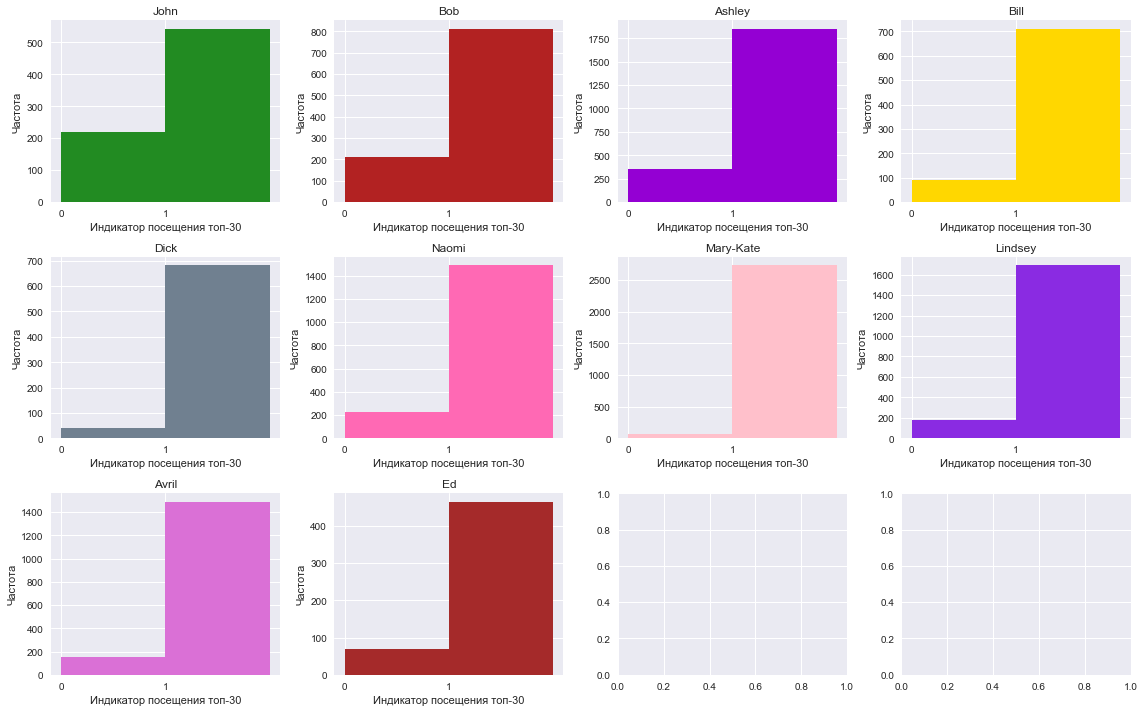

In [412]:
plt.hist(new_features_10users['popular_ind'],color="darkgreen",bins=[0,1,2])
plt.xticks([0,1])
plt.xlabel(u"Индикатор посещения топ-30")
plt.ylabel(u"Частота")
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')):
    row=int(idx/4)
    col=idx-row*4
    axes[row,col].hist(sub_df["popular_ind"].apply(lambda x: min(x,1000)),color=color_dic[id_name_dict[user]],bins=[0,1,2])
    axes[row,col].set_title(id_name_dict[user])
    axes[row,col].set_xlabel(u"Индикатор посещения топ-30")
    axes[row,col].set_ylabel(u"Частота")
    axes[row,col].set_xticks([0,1] )
fig.tight_layout()

Чаще всех на оригинальные сайты заходит John, реже всех - Mary-Kate.

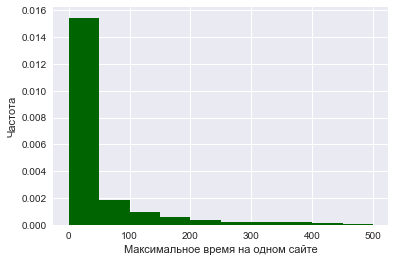

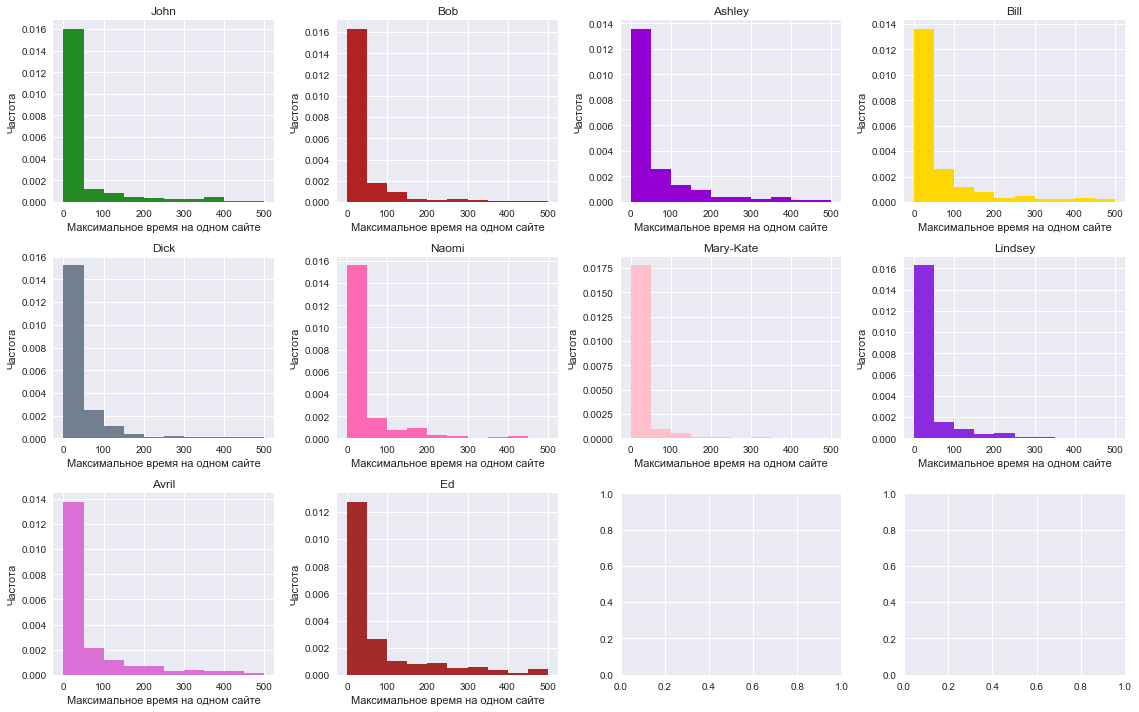

In [419]:
plt.hist(new_features_10users['max_time'],color="darkgreen",range=(0,500),normed=True)
plt.xlabel(u"Максимальное время на одном сайте")
plt.ylabel(u"Частота")
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')):
    row=int(idx/4)
    col=idx-row*4
    axes[row,col].hist(sub_df["max_time"],color=color_dic[id_name_dict[user]],range=(0,500),normed=True)
    axes[row,col].set_title(id_name_dict[user])
    axes[row,col].set_xlabel(u"Максимальное время на одном сайте")
    axes[row,col].set_ylabel(u"Частота")
fig.tight_layout()

Наименее склонна зависать на одном сайте Mary-Kate, наиболее склонен Ed.

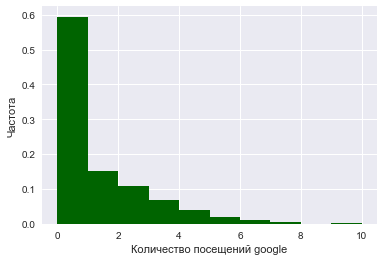

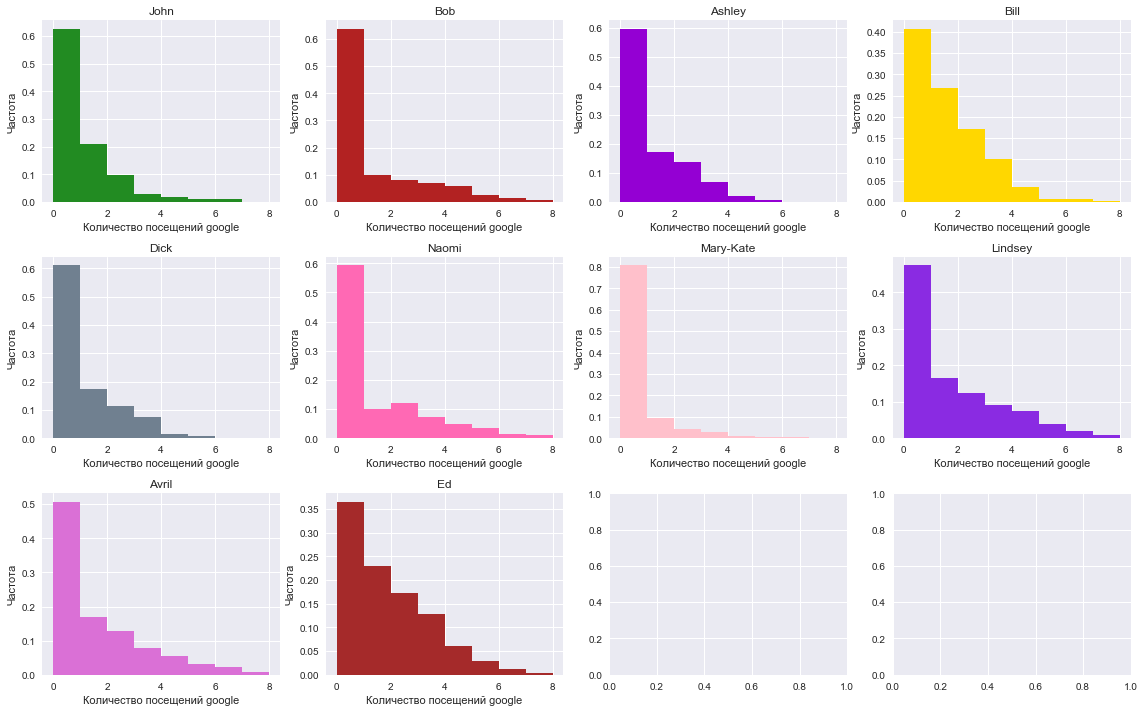

In [395]:
plt.hist(new_features_10users['av_visits_google'],color="darkgreen",normed=True)
plt.xlabel(u"Количество посещений google")
plt.ylabel(u"Частота")
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')):
    row=int(idx/4)
    col=idx-row*4
    axes[row,col].hist(sub_df["av_visits_google"],color=color_dic[id_name_dict[user]],bins=[0,1,2,3,4,5,6,7,8],normed=True)
    axes[row,col].set_title(id_name_dict[user])
    axes[row,col].set_xlabel(u"Количество посещений google")
    axes[row,col].set_ylabel(u"Частота")
fig.tight_layout()

google посещают все пользователи, достаточно часто. Чаще всех - Ed, реже всех - Mary-Kate.

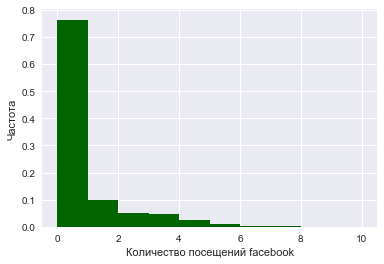

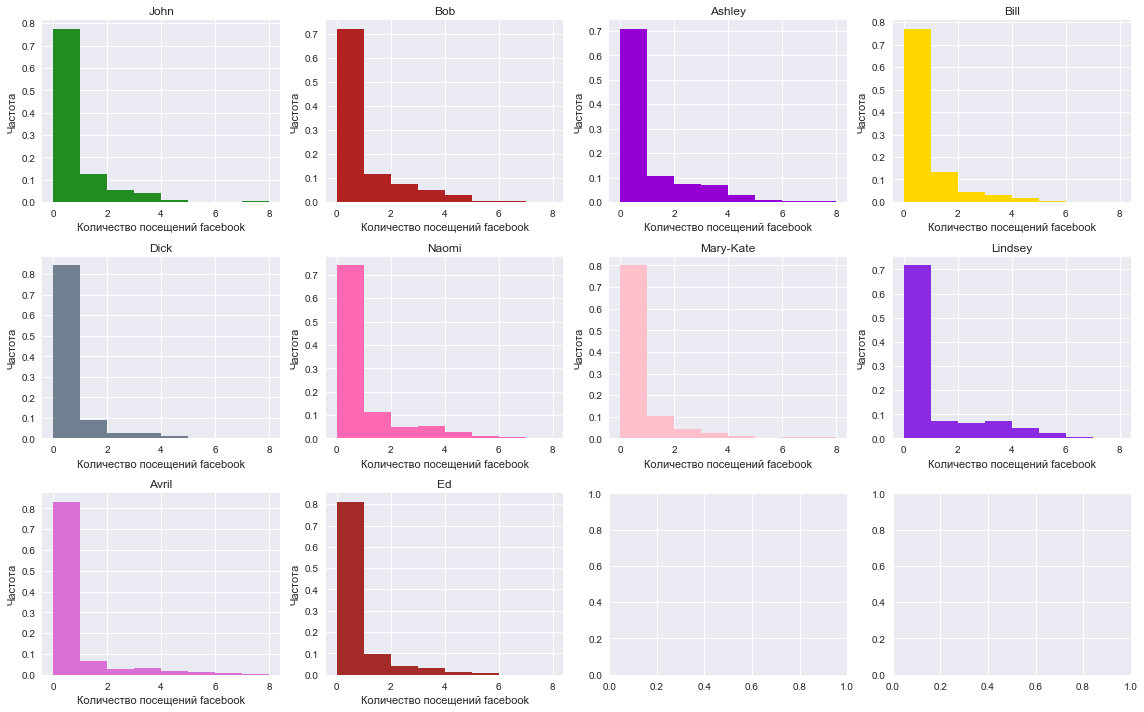

In [397]:
plt.hist(new_features_10users['av_visits_facebook'],color="darkgreen",normed=True)
plt.xlabel(u"Количество посещений facebook")
plt.ylabel(u"Частота")
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')):
    row=int(idx/4)
    col=idx-row*4
    axes[row,col].hist(sub_df["av_visits_facebook"],color=color_dic[id_name_dict[user]],bins=[0,1,2,3,4,5,6,7,8],normed=True)
    axes[row,col].set_title(id_name_dict[user])
    axes[row,col].set_xlabel(u"Количество посещений facebook")
    axes[row,col].set_ylabel(u"Частота")
fig.tight_layout()

На facebook почти одинаково чвсто заходят все пользователи. Как-то это странно.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [422]:
feature_names=["session_timespan","#unique_sites","start_hour","day_of_week","popular_ind","max_time"]
selected_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)
selected_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

In [423]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 